# [PBL] Corrective RAG Agent

## -1. 기획 의도 (배경)
- 👩‍🦰 "나만의 AI 챗봇을 만들고 싶어! 그런데 단순한 챗봇은 재미없잖아?"
- 🧓 "ChatGPT는 똑똑하지만, 내가 가진 **나만의 전문 문서**에 대해서는 잘 모른단 말이야. 예를 들어, 우리 회사 내부 규정이나 내가 정리한 논문 같은 것들 말이지."
- 👩‍🦱 "그래서 생각했어! 내가 가진 문서들을 학습시키고, 그 지식으로 답변해 주는 AI Agent를 만드는 거야. 그런데 여기서 끝내면 평범하지. 만약 AI가 내 문서에서 답을 못 찾으면 어쩌지? 그냥 '모르겠어요'라고 하는 건 너무 아쉽잖아."
- 👨‍🦲 "내 AI Agent는 **더 똑똑해야 해!** 만약 내 문서에 없는 내용이라면, 스스로 판단해서 **구글이나 인터넷에서 알아서 검색**하게 만드는 거야. 마치 내가 옆에 있는 똑똑한 비서처럼 말이야."
- 🧔🏾‍♀️ "그리고 가장 중요한 것! 내가 던진 질문에 AI가 찾은 문서들이 정말 유용한지 스스로 **판단하는 능력**을 넣어주고 싶어. 만약 찾은 정보가 엉뚱하다면, '이 정보는 별로네. 질문을 좀 더 구체적으로 바꿔서 다시 찾아봐야겠다'라고 생각하고 행동하게 만드는 거지. 이렇게 하면, 내 챗봇은 끊임없이 배우고, 완벽한 답변을 찾아내려고 노력할 거야. **'나도 AI Agent를 만들 수 있다!'** 이런 생각에서 시작된 나만의 **똑똑한 비서 만들기 프로젝트**야."

### TL;DR
> AI Agent를 이해하는 좋은 예제를 고민했어요. 그래서...
 1. ‘사용자가 한 번 질문하면, AI가 스스로 생각하고, 검색하고, 다시 묻고, 답을 고치는 과정’을 자동화한 시스템을 만들고 싶었습니다.
 2. 처음엔 단순한 문서 Q&A 챗봇이었지만, 곧 “DB 검색 → 답변 품질 평가 → 부족하면 웹 검색 → 검색어 재작성 → 최종 답변”이라는 에이전트적 사고 과정을 떠올렸습니다.
 3. 이 프로젝트는 결국 **“나도 AI Agent를 만들 수 있다”**라는 메시지를 담고 있습니다. 복잡한 것 같지만, 사실은 작은 단계들을 연결해 에이전트처럼 행동하게 한 것이 전부입니다. 이 예제를 통해서 다른 개발자들도 “별거 없네~! 나도 문서 + 웹 검색 + 자동 답변 고도화를 결합해서 나만의 AI 비서를 만들어보고 싶다!”라는 욕구가 생기도록 하는 것이 최초의 기획 의도였습니다.

## 0. 코드의 주요 기능 요약
아래 코드는 LangChain과 LangGraph를 활용하여 **Corrective RAG(검색 증강 생성)** 시스템을 구현한 것입니다.

-  **RAG 워크플로우**: LangGraph를 사용해 문서 검색, 관련성 평가, 답변 생성, 쿼리 재작성 등의 단계를 자동화하는 에이전트 워크플로우를 구축합니다.
-  **다중 소스 검색**: 내부 문서(DB)에서 정보를 먼저 검색하고, 만약 관련성이 낮다고 판단되면 자동으로 쿼리를 재작성하여 외부 웹(Tavily Search)에서 정보를 검색합니다.
-  **동적 관련성 평가**: 검색된 문서가 사용자의 질문과 얼마나 관련 있는지 **코사인 유사도**를 이용해 평가합니다. 이 점수가 낮으면 재시도 로직을 트리거합니다.
-  **유지보수 및 확장성**: `CorrectiveRAG`라는 클래스에 모든 기능을 캡슐화하여, 코드의 재사용성과 유지보수성을 높였습니다.
-  **다양한 파일 형식 지원**: PDF, 텍스트, 마크다운 등 여러 형식의 문서를 로드하고 처리할 수 있습니다.

이 시스템은 정해진 지식만으로 답변하기 어려운 상황에서 외부 지식을 동적으로 활용하여 답변의 정확도를 높이는 것을 목표로 합니다.

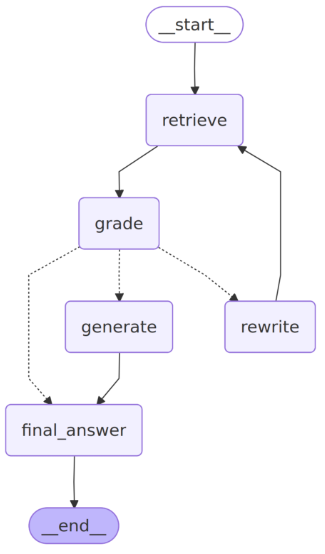

## 1. 환경 설정

구현에 필요한 모든 모듈을 import합니다.   
LangChain의 핵심 컴포넌트들, 문서 처리 도구, 벡터 데이터베이스, 임베딩 모델, 웹 검색 도구, 그리고 유사도 계산을 위한 scikit-learn을 포함합니다.

In [1]:
import os
from datetime import datetime
from typing import Any, Dict, List, Literal, TypedDict

import numpy as np
from langchain.text_splitter import RecursiveCharacterTextSplitter

# --- 데이터 처리 및 RAG 관련 모듈 ---
from langchain_community.document_loaders import PyMuPDFLoader, UnstructuredFileLoader
from langchain_community.vectorstores import Chroma

# --- LangChain 및 LangGraph 핵심 모듈 ---
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableConfig
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_tavily import TavilySearch
from langgraph.graph import END, StateGraph

# --- 유틸리티 ---
from sklearn.metrics.pairwise import cosine_similarity

ModuleNotFoundError: No module named 'sklearn'

## 2. API 키 설정

In [ ]:
import os

from dotenv import load_dotenv

# .env 파일 로드, 환경 변수에서 API 키 읽기
load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

## 3. 상태 관리

Corrective RAG의 워크플로우에서 사용할 상태 객체를 정의합니다.    
사용자 질문, 검색 결과, 답변, 재시도 횟수, 현재 쿼리, 관련성 점수, 검색 소스(DB/웹) 등 모든 필요한 정보를 포함합니다.

✏️이 부분은 **에이전트가 기억해야 할 상태(State)**를 정의하는 단계입니다.

---

### 코드 설명 (처음 접하는 개발자 시점)

이 코드는 `CorrectiveAgentState`라는 이름의 **상태 저장소**를 만드는 거예요.
쉽게 말하면, **에이전트의 다이어리** 같은 겁니다.

* `user_question`: 사용자가 한 질문 (예: "피싱 메일 대응 방법은?")
* `search_results`: 검색된 문서들의 목록
* `final_answer`: 마지막으로 생성된 답변
* `retry_count`: 몇 번 다시 시도했는지 기록 (검색 실패 → 쿼리 재작성 같은 경우)
* `max_retries`: 최대 몇 번까지 재시도할 수 있는지 제한
* `current_query`: 지금 검색하고 있는 쿼리 (원래 질문을 재작성했을 수도 있음)
* `relevance_score`: 질문과 문서가 얼마나 관련 있는지 점수
* `docs_are_relevant`: 문서가 관련 있는지 여부 (True/False)
* `search_source`: 어디서 검색할지 ("db" → 벡터DB, "web" → 인터넷)

---

### 비유로 쉽게 이해하기

이걸 **탐험가 노트**라고 생각하면 됩니다.

* `user_question`: 탐험가가 받은 미션(질문)
* `search_results`: 지금까지 찾아낸 단서들
* `final_answer`: 최종 보고서
* `retry_count` / `max_retries`: 같은 장소를 몇 번까지 다시 탐험할지
* `current_query`: 지금 손에 들고 있는 지도(검색어)
* `relevance_score`: 단서가 미션과 얼마나 관련 있는지 점수
* `docs_are_relevant`: 단서가 쓸모 있는지 여부
* `search_source`: "도서관(DB)"에서 찾을지, "인터넷(Web)"에서 찾을지

즉, 에이전트가 답변을 만들어내기 위해 **탐험하면서 상태를 기록하는 다이어리**라고 보면 됩니다.

In [ ]:
class CorrectiveAgentState(TypedDict):
    user_question: str
    search_results: List[Document]
    final_answer: str
    retry_count: int
    max_retries: int
    current_query: str
    relevance_score: float
    docs_are_relevant: bool
    search_source: str

## 4. 핵심 함수
Corrective RAG의 핵심 로직을 담당하는 5개의 노드 함수들을 구현합니다:
- `retrieve_node`: DB 또는 웹에서 문서 검색
- `grade_node`: 임베딩 유사도 기반으로 검색 결과 품질 평가
- `generate_answer_node`: 검색 결과를 바탕으로 답변 생성
- `rewrite_query_node`: 품질이 낮을 때 쿼리 재작성
- `final_answer_node`: 최종 답변 결정

🙌 이제 에이전트의 첫 번째 “행동 단계”인 **검색 노드** 코드네요.

---

### 코드 설명 (처음 접하는 개발자 시점)

이 함수는 `retrieve_node`라는 이름 그대로, **정보를 검색하는 역할**을 합니다.
에이전트가 “도서관(DB)에서 찾을까, 아니면 인터넷(Web)에서 찾을까?”를 결정해서 자료를 가져오는 과정이에요.

1. `source = state.get("search_source", "db")`
   → 지금 검색할 장소가 어디인지 확인합니다. 기본은 `"db"`예요.

2. 만약 `"db"`이면:

   * `retriever.get_relevant_documents(state["current_query"])`를 이용해 벡터DB에서 비슷한 문서를 꺼내옵니다.
   * 예: “피싱 메일”이라는 질문 → 피싱 관련 PDF 문서 조각들을 가져옴.

3. 만약 `"web"`이면:

   * `TavilySearch`라는 웹 검색 도구를 사용합니다.
   * 실제로 인터넷에서 검색한 뒤, 결과를 `Document` 형태로 변환합니다. (제목/내용/URL 포함)
   * 즉, 구글 검색 후 정리된 노트를 만드는 느낌이에요.

4. 마지막으로 `{"search_results": search_results}` 형태로 결과를 반환합니다.

---

### 비유로 쉽게 이해하기

이 과정을 **탐험가의 자료 수집**에 비유해볼게요.

* `search_source == "db"` → 탐험가는 **도서관**에 가서 책을 꺼냅니다.
* `search_source == "web"` → 탐험가는 \*\*인터넷 카페(웹)\*\*에 가서 최신 소문을 모읍니다.
* 찾은 자료는 다이어리(`state`)에 기록해둡니다.

즉, 이 함수는 에이전트에게 \*\*“필요한 정보를 어디서 찾을지 정하고 가져오는 탐색 단계”\*\*를 맡깁니다.

In [ ]:
def retrieve_node(state: CorrectiveAgentState, config: RunnableConfig) -> Dict[str, Any]:
    """문서 검색 (DB 또는 웹)"""
    source = state.get("search_source", "db")
    print(f"{source.upper()} 검색")

    if source == "db":
        retriever = config["configurable"]["retriever"]
        search_results = retriever.get_relevant_documents(state["current_query"])
        print(f"   - {len(search_results)}개 DB 문서 검색 완료")
    else:  # web
        try:
            # search_tool = TavilySearchResults(max_results=5)
            search_tool = TavilySearch(k=5)
            web_results = search_tool.invoke(state["current_query"])

            search_results = []
            for result in web_results:
                doc = Document(
                    page_content=f"제목: {result.get('title', '')}\n내용: {result.get('content', '')}",
                    metadata={"source": "web", "url": result.get("url", "")},
                )
                search_results.append(doc)
            print(f"   - {len(search_results)}개 웹 검색 결과")
        except Exception as e:
            print(f"   - 웹 검색 실패: {e}")
            search_results = []

    return {"search_results": search_results}


👍 이제 검색된 자료가 **정말 쓸모 있는지 평가하는 단계**네요.

---

### 코드 설명 (처음 접하는 개발자 시점)

이 함수는 `grade_node`로, 한마디로 말하면 **“자료 심사관”**입니다.
검색해 온 문서들이 사용자의 질문과 관련 있는지 확인해 점수를 매깁니다.

1. `if not state["search_results"]:`
   → 검색 결과가 아예 없으면, 점수 0.0에 “비관련” 판정.

2. `question_embedding = embedding_model.embed_query(state["user_question"])`
   → 질문을 숫자 벡터(embedding)로 바꿉니다.
   → 예: “피싱 메일 대응” → `[0.12, -0.3, 0.87, ...]`

3. 각 문서에 대해서:

   * 문서 내용도 embedding으로 변환.
   * `cosine_similarity`로 질문과 문서의 유사도를 계산.
   * 1에 가까울수록 관련성 높음, 0에 가까울수록 무관함.

4. 평균 유사도를 구해서 기준치(0.5) 이상이면 `docs_are_relevant = True`, 아니면 False.

---

### 비유로 쉽게 이해하기

이 과정을 **채용 면접관**에 비유해보죠.

* `user_question`: 회사가 원하는 역량(채용 공고).
* `search_results`: 지원자들의 이력서(검색된 문서들).
* `embedding_model`: 번역기 + 점수 계산기 (이력서를 다 숫자로 바꿔서 비교 가능하게 함).
* `cosine_similarity`: 이력서와 채용 공고의 적합도를 계산하는 도구.
* `avg_similarity >= 0.5`: “이 지원자는 합격선 이상이다!”

즉, 이 단계는 검색한 문서가 **질문과 진짜로 관련 있는지 점검하는 심사관 역할**입니다.

In [ ]:
def grade_node(state: CorrectiveAgentState, config: RunnableConfig) -> Dict[str, Any]:
    """문서 관련성 평가 (DB/웹 공통)"""
    source = state.get("search_source", "db")
    print(f"{source.upper()} 검색 결과 평가")

    embedding_model = config["configurable"]["embedding_model"]

    if not state["search_results"]:
        return {"relevance_score": 0.0, "docs_are_relevant": False}

    # 질문 임베딩
    question_embedding = embedding_model.embed_query(state["user_question"])

    # 문서들 임베딩 및 유사도 계산
    similarities = []
    for doc in state["search_results"]:
        doc_embedding = embedding_model.embed_query(doc.page_content)
        similarity = cosine_similarity([question_embedding], [doc_embedding])[0][0]
        similarities.append(similarity)

    # 평균 유사도
    avg_similarity = np.mean(similarities)
    docs_are_relevant = avg_similarity >= 0.5

    print(f"   평균 유사도: {avg_similarity:.3f}")
    print(f"   관련성 판정: {'관련' if docs_are_relevant else '비관련'}")

    return {"relevance_score": avg_similarity, "docs_are_relevant": docs_are_relevant}

이제 드디어 하이라이트! 🎉 
검색한 문서를 가지고 **실제 답변을 만들어내는 단계**입니다.

---

### 코드 설명 (처음 접하는 개발자 시점)

이 함수는 `generate_answer_node`, 즉 **답변 생성 노드**예요.
이제 검색 → 심사 단계를 거쳐 남은 문서들을 기반으로 LLM이 답변을 만듭니다.

1. `llm = ChatOpenAI(model=..., temperature=0)`
   → OpenAI의 챗 모델을 불러옵니다.
   → `temperature=0`은 창의적 답변 대신 **사실 기반으로 차분한 답변**을 하게 만듭니다.

2. `context = "\n\n".join([...])`
   → 검색된 문서 내용을 하나로 묶어서 LLM에게 제공할 \*\*참고 자료(context)\*\*를 만듭니다.

3. `ChatPromptTemplate.from_messages([...])`
   → LLM에게 줄 지시문(prompt)을 구성합니다.

   * `"system"`: “검색 결과를 기반으로 답변하라”라는 역할 지시.
   * `"human"`: 실제로 사용자 질문과 문서 내용을 넣어 답변을 유도.

4. `(prompt | llm).invoke(...)`
   → `prompt`와 `llm`을 파이프라인처럼 연결해서 실행.
   → 즉, “문맥(context) + 질문”을 모델에게 던지고 답변을 받습니다.

5. 결과는 `{"final_answer": response.content}` 형태로 저장.

---

### 비유로 쉽게 이해하기

이 과정을 **전문가 보고서 작성**에 비유해봅시다.

* `search_results`: 조사원들이 모아온 참고 문서 더미.
* `context`: 그 문서를 정리해놓은 “브리핑 자료”.
* `system`: “너는 참고 문서만 근거로 삼아라”라는 규칙.
* `human`: “자, 이 자료를 보고 이 질문에 답을 해줘”라는 요청.
* `llm`: 똑똑한 연구원이 보고서를 작성.

즉, 이 단계는 에이전트가 **자료를 바탕으로 질문에 맞는 보고서를 작성하는 순간**입니다.

In [ ]:
def generate_answer_node(state: CorrectiveAgentState, config: RunnableConfig) -> Dict[str, Any]:
    """답변 생성"""
    source = state.get("search_source", "db")
    print(f"답변 생성 ({source} 소스)")

    llm = ChatOpenAI(model=config["configurable"]["model_name"], temperature=0)

    context = "\n\n".join([doc.page_content for doc in state["search_results"]])

    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", "검색 결과를 기반으로 질문에 답변하세요."),
            ("human", "검색 결과:\n{context}\n\n질문: {question}\n\n답변:"),
        ]
    )

    response = (prompt | llm).invoke({"context": context, "question": state["user_question"]})

    return {"final_answer": response.content}

🎯 이제는 검색한 결과가 부족할 때, **질문을 다시 쓰는 단계**예요.

---

### 코드 설명 (처음 접하는 개발자 시점)

이 함수는 `rewrite_query_node`, 즉 **쿼리 재작성 노드**입니다.
검색에서 충분한 자료를 못 찾았을 때, 더 좋은 검색어로 고쳐주는 역할을 합니다.

1. `llm = ChatOpenAI(...)`
   → LLM을 불러옵니다. (창의성이 필요 없으므로 `temperature=0`)

2. `prompt = ChatPromptTemplate.from_messages([...])`

   * `"system"`: “검색 결과가 부족하면, 검색어를 더 구체적으로 다시 쓰라”는 규칙.
   * `"human"`: “원래 질문이 이거였는데, 더 나은 검색어를 만들어줘”라는 요청.

3. `(prompt | llm).invoke(...)`
   → 질문을 넣으면, LLM이 새로운 검색어를 반환합니다.

   * 예: 원래 질문 → “GPT-5 정보 알려줘”
   * 재작성된 쿼리 → “GPT-5 최근 출시일과 주요 기능”

4. 반환하는 state 업데이트:

   * `"current_query"`: 새로 만든 검색어로 교체.
   * `"retry_count"`: 재시도 횟수 +1.
   * `"search_source"`: 이번에는 **웹 검색**으로 변경.

---

### 비유로 쉽게 이해하기

이건 마치 **탐험가가 길을 잃었을 때, 지도를 다시 그리는 과정**과 같습니다.

* 원래 지도(`user_question`)만으로는 보물이 안 나옴.
* 전문가(LLM)가 새로운 지도(`current_query`)를 만들어 줌.
* “도서관에서 찾을 게 아니라, 인터넷에서 뒤져봐라”라고 검색 소스를 전환.
* 동시에 재시도 횟수를 올려서, 무한 루프에 빠지지 않도록 제한.

즉, 이 단계는 에이전트가 \*\*검색을 보정하고 새로운 길을 찾는 “재탐색 단계”\*\*입니다.

In [ ]:
def rewrite_query_node(state: CorrectiveAgentState, config: RunnableConfig) -> Dict[str, Any]:
    """쿼리 재작성"""
    print("쿼리 재작성")

    llm = ChatOpenAI(model=config["configurable"]["model_name"], temperature=0)

    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", "검색 결과가 부족한 경우, 더 구체적이고 명확한 검색어로 재작성하세요."),
            ("human", "원래 질문: {question}\n\n재작성된 검색어:"),
        ]
    )

    response = (prompt | llm).invoke({"question": state["user_question"]})
    print(f"재작성된 쿼리: {response.content}")

    return {
        "current_query": response.content,
        "retry_count": state["retry_count"] + 1,
        "search_source": "web",  # 재작성 후에는 웹 검색
    }

🙌 이제 드디어 **마지막 단계: 최종 답변 정리** 단계예요.

---

### 코드 설명 (처음 접하는 개발자 시점)

이 함수는 `final_answer_node`, 즉 **최종 답변 노드**입니다.
앞에서 여러 단계(검색 → 평가 → 답변 생성 → 필요 시 재검색)를 거쳤다면, 이제는 결과를 마무리하는 자리예요.

1. `if state["retry_count"] >= state["max_retries"]:`
   → 재시도 횟수가 한도를 초과하면,
   → “죄송합니다. 정보를 찾을 수 없습니다.”라는 **최종 답변**을 반환합니다.

2. 그렇지 않으면,
   → 앞에서 만들어둔 `state["final_answer"]`를 그대로 돌려줍니다.

---

### 비유로 쉽게 이해하기

이 단계는 마치 **시험 감독관이 시험 종료를 알리고 답안지를 제출시키는 순간**과 비슷합니다.

* 학생(에이전트)은 여러 번 문제를 풀어보려고 시도했음. (`retry_count`)
* 정해진 시간(=최대 재시도 횟수 `max_retries`)을 넘으면 **그냥 불합격 처리**.
* 그렇지 않으면, 작성한 답안(`final_answer`)을 제출.

즉, 이 단계는 **시스템이 결과를 안전하게 확정짓는 결론부**입니다.

In [ ]:
def final_answer_node(state: CorrectiveAgentState, config: RunnableConfig) -> Dict[str, Any]:
    """최종 답변"""
    if state["retry_count"] >= state["max_retries"]:
        return {"final_answer": "죄송합니다. 충분한 정보를 찾을 수 없어 답변을 생성할 수 없습니다."}
    else:
        return {"final_answer": state["final_answer"]}

👏 이제 핵심 클래스 **`CorrectiveRAG`**가 등장했네요.
앞에서 만든 여러 노드들을 하나의 **에이전트 시스템**으로 묶는 본체라고 볼 수 있습니다.

---

### 코드 설명 (처음 배우는 개발자 시점)

`CorrectiveRAG` 클래스는 크게 세 부분으로 나뉩니다:

#### 1. `__init__`

* `self.model_name`: 사용할 LLM 이름 (기본값: `"gpt-4o-mini"`).
* `self.embedding_model`: 텍스트를 숫자로 바꿔주는 임베딩 모델 (검색과 관련성 평가에 사용).
* `self.workflow`: 곧 설명할 워크플로우(StateGraph)를 만들어 저장.

👉 즉, **AI 에이전트를 초기화하는 단계**입니다.
비유하자면, “탐험가 + 지도 + 탐험 루트(워크플로우)”를 준비하는 과정이에요.

---

#### 2. `_build_workflow`

* `workflow = StateGraph(CorrectiveAgentState)`
  → 그래프 형태의 워크플로우를 정의합니다. (상태 머신이라고 생각하면 쉬움)

* 노드 추가:
  `"retrieve"`(검색) → `"grade"`(평가) → `"generate"`(답변 생성) → `"final_answer"`
  중간에 `"rewrite"`(쿼리 재작성)도 들어갈 수 있음.

* 조건 분기 (`should_retry`):

  * **재시도 횟수 초과** → `"final_answer"`로 바로 이동
  * **관련 없는 결과** → `"rewrite"`로 이동
  * **충분히 관련 있음** → `"generate"`로 이동

* 마지막으로 `workflow.compile()`로 그래프를 실제 실행 가능한 상태로 완성.

👉 즉, 이 부분은 **탐험가가 어떤 상황에서 어디로 이동해야 할지 그린 지도로 비유**할 수 있어요.
(예: “자료 없으면 다시 검색, 있으면 답변 생성, 최대 횟수 넘으면 종료”)

---

#### 3. `setup_documents`

* 주어진 파일들을 **불러와서 전처리 후 벡터DB(Chroma)에 저장**합니다.
* 단계별로 보면:

  1. 파일 로드 (PDF는 `PyMuPDFLoader`, 그 외는 `UnstructuredFileLoader`)
  2. 텍스트 분할 (청킹, `RecursiveCharacterTextSplitter`)
  3. 불필요한 메타데이터 제거
  4. Chroma 벡터DB에 저장, `retriever`로 변환

👉 이 과정은 “탐험가가 참고할 \*\*도서관(DB)\*\*을 만드는 과정”이라고 생각하면 됩니다.

---

#### 4. `ask`

* 사용자의 질문을 받아 초기 상태(`initial_state`)를 만듭니다.
* 설정(`config`)에 retriever, 모델 이름, embedding\_model을 담아 전달.
* `self.workflow.invoke(...)`로 워크플로우 실행.
* 최종 답변을 출력.

👉 쉽게 말하면, \*\*“질문이 들어오면 → 미리 만들어둔 지도(워크플로우)에 따라 탐험을 시작해서 → 답변을 들고 돌아오는 함수”\*\*입니다.

---

### 전체 비유

`CorrectiveRAG`는 하나의 **탐험대 운영 본부** 같은 존재예요.

* `setup_documents` → 도서관을 준비
* `_build_workflow` → 탐험 루트를 설계
* `ask` → 질문이 들어오면 탐험가가 정해진 루트에 따라 답을 찾아옴

## 5. Corrective RAG Agent 클래스
전체 Corrective RAG 시스템을 캡슐화한 메인 클래스입니다.    
워크플로우 구성, 문서 설정, 질의응답 기능을 제공하며, HuggingFace 임베딩 모델을 사용하여 벡터 검색을 수행합니다.

In [ ]:
class CorrectiveRAG:
    def __init__(self, model_name="gpt-4o-mini"):
        self.model_name = model_name
        self.retriever = None

        # 임베딩 모델
        self.embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")

        self.workflow = self._build_workflow()


    def _build_workflow(self):
        """Corrective RAG 워크플로우"""
        workflow = StateGraph(CorrectiveAgentState)

        # 노드 추가
        workflow.add_node("retrieve", retrieve_node)
        workflow.add_node("grade", grade_node)
        workflow.add_node("generate", generate_answer_node)
        workflow.add_node("rewrite", rewrite_query_node)
        workflow.add_node("final_answer", final_answer_node)

        # 시작점 설정
        workflow.set_entry_point("retrieve")

        # 기본 흐름
        workflow.add_edge("retrieve", "grade")

        # 평가 후 분기
        def should_retry(state):
            if state["retry_count"] >= state["max_retries"]:
                print(f"   - 최대 시도 횟수 도달 ({state['max_retries']}회)")
                return "final_answer"

            if not state["docs_are_relevant"]:
                print(f"   - 재시도 필요: 유사도 점수 낮음 ({state['relevance_score']:.3f} < 0.5)")
                return "rewrite"
            else:
                print(f"   - 품질 통과: 유사도 점수 충분 ({state['relevance_score']:.3f} >= 0.5)")
                return "generate"

        workflow.add_conditional_edges(
            "grade", should_retry, {"rewrite": "rewrite", "generate": "generate", "final_answer": "final_answer"}
        )

        # 나머지 엣지
        workflow.add_edge("generate", "final_answer")
        workflow.add_edge("rewrite", "retrieve")
        workflow.add_edge("final_answer", END)

        return workflow.compile()

    def setup_documents(self, input_files: List[str]):
        """문서 초기 설정"""
        print("문서 설정 시작")

        # 문서 로딩
        all_docs = []
        for file_path in input_files:
            try:
                print(f"   로딩 중: {os.path.basename(file_path)}")

                if file_path.endswith(".pdf"):
                    loader = PyMuPDFLoader(file_path)
                else:
                    loader = UnstructuredFileLoader(file_path, mode="elements")

                docs = loader.load()
                all_docs.extend(docs)
                print(f"   - 로드 성공: {len(docs)}개 문서")

            except Exception as e:
                print(f"   - 로드 실패: {e}")

        # 문서 청킹
        text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
        chunked_docs = text_splitter.split_documents(all_docs)

        # 메타데이터 제거
        clean_docs = []
        for doc in chunked_docs:
            clean_doc = Document(page_content=doc.page_content, metadata={})
            clean_docs.append(clean_doc)

        # 벡터 DB 생성
        print("벡터 DB 생성 중...")
        vectorstore = Chroma.from_documents(documents=clean_docs, embedding=self.embedding_model)
        self.retriever = vectorstore.as_retriever(search_kwargs={"k": 5})

        print("설정 완료")
    

    def ask(self, question: str) -> str:
        """질문에 답변"""
        initial_state = {
            "user_question": question,
            "search_results": [],
            "final_answer": "",
            "retry_count": 0,
            "max_retries": 2,
            "current_query": question,
            "relevance_score": 0.0,
            "docs_are_relevant": True,
            "search_source": "db",  # 처음에는 DB 검색
        }

        config = {
            "configurable": {
                "model_name": self.model_name,
                "retriever": self.retriever,
                "embedding_model": self.embedding_model,
            }
        }

        print(f"\n질문: {question}")
        print("=" * 60)

        final_state = self.workflow.invoke(initial_state, config=config)

        print("=" * 60)
        print("최종 답변:")

        return final_state["final_answer"]
    
    def get_workflow(self):
        return self.workflow

👍 이제 드디어 **데이터 준비 단계**가 나왔네요.
앞에서 만든 `CorrectiveRAG` 클래스를 실제로 써먹기 시작하는 부분이에요.

---

### 코드 설명 (처음 배우는 개발자 시점)

#### 1. 데이터셋 경로 설정

```python
dataset_path = "./data/"
filenames = [...]
files_to_process = [os.path.join(dataset_path, f) for f in filenames]
```

* 우리가 사용할 문서들이 `./data/` 폴더 안에 있다고 가정합니다.
* `filenames`에는 PDF, PPTX, Markdown 같은 다양한 파일들이 들어 있어요.
* `files_to_process`는 전체 경로까지 붙인 파일 목록을 만든 것입니다.
  (예: `"./data/피싱_메일_공격_사례_분석_및_대응_방안.pdf"`)

👉 즉, \*\*“탐험할 자료가 있는 책들의 목록을 만든 것”\*\*이라고 생각하면 돼요.

---

#### 2. CorrectiveRAG 에이전트 생성

```python
agent = CorrectiveRAG()
```

* 앞에서 만든 \*\*CorrectiveRAG 시스템(탐험대 본부)\*\*을 하나 생성합니다.
* 여기서 아직 데이터는 연결하지 않은 상태입니다. (빈 도서관)

---

#### 3. 문서 세팅

```python
agent.setup_documents(files_to_process)
```

* 우리가 지정한 파일들을 로딩해서 → 텍스트로 나누고 → 벡터DB(Chroma)에 저장합니다.
* 이 과정이 끝나면, 에이전트는 **내부 DB 검색 기능**을 쓸 준비가 완료됩니다.

👉 비유하자면, “도서관에 책들을 꽂아놓고, 사서가 준비 완료!” 된 상황이에요.

---

### 요약

이 블록까지 실행하면, 이제 에이전트는 **자기만의 도서관을 가진 똑똑한 비서**가 된 거예요.
이제 우리는 `agent.ask("질문")`만 실행하면 바로 답변을 얻을 수 있습니다. 🚀

## 6. 에이전트 실행 및 테스트

In [ ]:
# 파일 경로 설정
dataset_path = "./data/"
filenames = [
    "Retrieval-Augmented Generation for Knowledge-Intensive NLP Tasks (2020, Facebook AI).pdf",
    "서울시_산학연_협력사업_운영요령_개정_전문.pdf",
    "피싱_메일_공격_사례_분석_및_대응_방안.pdf",
    "[이론1] Advanced RAG 개요.pptx",
    "README.md",
]
files_to_process = [os.path.join(dataset_path, f) for f in filenames]

# 에이전트 생성 및 설정
agent = CorrectiveRAG()
agent.setup_documents(files_to_process)

문서 설정 시작
   로딩 중: Retrieval-Augmented Generation for Knowledge-Intensive NLP Tasks (2020, Facebook AI).pdf
   - 로드 성공: 19개 문서
   로딩 중: 서울시_산학연_협력사업_운영요령_개정_전문.pdf
   - 로드 성공: 27개 문서
   로딩 중: 피싱_메일_공격_사례_분석_및_대응_방안.pdf
   - 로드 성공: 40개 문서
   로딩 중: [이론1] Advanced RAG 개요.pptx


/tmp/ipykernel_9633/2928849589.py:68: LangChainDeprecationWarning: The class `UnstructuredFileLoader` was deprecated in LangChain 0.2.8 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-unstructured package and should be used instead. To use it run `pip install -U :class:`~langchain-unstructured` and import as `from :class:`~langchain_unstructured import UnstructuredLoader``.
  loader = UnstructuredFileLoader(file_path, mode="elements")


   - 로드 실패: partition_pptx() is not available because one or more dependencies are not installed. Use: pip install "unstructured[pptx]" (including quotes) to install the required dependencies
   로딩 중: README.md
   - 로드 실패: partition_md() is not available because one or more dependencies are not installed. Use: pip install "unstructured[md]" (including quotes) to install the required dependencies
벡터 DB 생성 중...
설정 완료


## 7. 테스트 예제
구현된 Corrective RAG Agent의 실제 사용을 테스트해 봅니다.     
시스템이 어떻게 DB 검색과 웹 검색을 자동으로 조합하여 답변을 생성하는지 확인할 수 있습니다.  

좋아요! 이제 **실제 질문을 던지고 답변을 받는 단계**입니다. 📝

---

### 코드 설명 (처음 배우는 개발자 시점)

```python
answer_text = agent.ask(question="피싱 메일 공격에 대한 기술적 대응 방안을 설명해줘.")
print(answer_text)
```

1. `agent.ask(...)`

   * 우리가 준비한 **CorrectiveRAG 에이전트**에게 질문을 전달합니다.
   * 내부적으로는 **검색 → 평가 → 답변 생성 → 필요 시 재검색 → 최종 답변**까지 자동으로 수행합니다.

2. 질문 내용

   * `"피싱 메일 공격에 대한 기술적 대응 방안"`
   * 데이터베이스(DB)에 관련 문서가 있기 때문에, 에이전트는 **내부 자료를 우선 참조**해서 답을 만듭니다.

3. `print(answer_text)`

   * 최종 답변을 화면에 출력합니다.
   * LLM이 생성한 답변이 **즉시 확인 가능**합니다.

---

### 비유로 쉽게 이해하기

* 질문: “탐험가야, 피싱 공격 대응책 알려줘.”
* 에이전트: 도서관에서 관련 자료를 찾아, 내용을 요약하고 보고서처럼 정리.
* 결과: 답변이 화면에 출력됨 → 즉, \*\*“보고서가 완성되어 제출”\*\*된 상태입니다.

---

이 단계는 **DB에 관련 내용이 있을 때 정상적으로 작동하는 흐름**을 보여주는 예제입니다. ✅

In [ ]:
# 예시 1: DB에 관련 내용이 있는 질문
answer_text = agent.ask(question="피싱 메일 공격에 대한 기술적 대응 방안을 설명해줘.")
print(answer_text)


질문: 피싱 메일 공격에 대한 기술적 대응 방안을 설명해줘.
DB 검색


/tmp/ipykernel_9633/474133858.py:8: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  search_results = retriever.get_relevant_documents(state["current_query"])


   - 5개 DB 문서 검색 완료
DB 검색 결과 평가
   평균 유사도: 0.624
   관련성 판정: 관련
   - 품질 통과: 유사도 점수 충분 (0.624 >= 0.5)
답변 생성 (db 소스)
최종 답변:
피싱 메일 공격에 대한 기술적 대응 방안은 다음과 같습니다:

1. **메일 필터링 및 스팸 차단**: 이메일 서버에 스팸 필터링 솔루션을 도입하여 의심스러운 메일을 자동으로 차단하거나 격리합니다. 이를 통해 피싱 메일이 사용자에게 도달하기 전에 차단할 수 있습니다.

2. **보안메일 사용**: 기업 및 기관에서는 보안메일을 사용하여 중요한 정보를 보호합니다. 그러나 공격자가 보안메일을 위장할 수 있으므로, 사용자에게 보안메일의 진위 여부를 확인하는 절차를 교육해야 합니다.

3. **메일 클라이언트 및 웹 메일 취약점 패치**: 메일 클라이언트와 웹 메일 서비스의 보안 취약점을 주기적으로 점검하고, 최신 보안 패치를 적용하여 악성 스크립트가 실행되지 않도록 합니다.

4. **사용자 교육 및 인식 제고**: 사용자에게 피싱 메일의 특징과 위험성을 교육하여, 의심스러운 메일을 클릭하지 않도록 합니다. 예를 들어, 발신자의 이메일 주소를 확인하고, 링크를 클릭하기 전에 URL을 점검하는 방법을 교육합니다.

5. **다단계 인증(2FA) 도입**: 계정 보안을 강화하기 위해 다단계 인증을 도입하여, 비밀번호가 유출되더라도 추가적인 인증 절차를 요구함으로써 계정 탈취를 방지합니다.

6. **로그 모니터링 및 경고 시스템**: 비정상적인 로그인 시도나 계정 활동을 모니터링하고, 의심스러운 활동이 감지되면 즉시 경고를 발송하여 사용자가 신속하게 대응할 수 있도록 합니다.

7. **피싱 사이트 차단**: 피싱 사이트를 신속하게 차단하기 위해, 보안 솔루션을 통해 알려진 피싱 사이트 목록을 업데이트하고, 사용자가 해당 사이트에 접근하지 못하도록 차단합니다.

이러한 기술적 대응 방안들은 피싱 메일 공격의 위험을 줄이고, 사용자와 기업의 정보를 보호하는 

좋아요! 이제 **DB에 관련 내용이 없는 질문**을 던져서, 에이전트가 **재검색과 쿼리 재작성 기능**까지 동작하는 모습을 볼 수 있습니다. 🔄

---

### 코드 설명 (처음 배우는 개발자 시점)

```python
answer_text = agent.ask(question="최근 출시된 GPT-5에 대한 정보 알려줘")
print(answer_text)
```

1. 질문: `"최근 출시된 GPT-5에 대한 정보 알려줘"`

   * 데이터베이스(DB)에는 관련 문서가 없어요.
   * 따라서 에이전트는 **검색 결과가 부족함**을 감지합니다.

2. 자동으로 수행되는 과정:

   * **`grade_node`**: 검색 결과 관련성 평가 → 유사도 낮음 → `docs_are_relevant = False`
   * **`rewrite_query_node`**: 질문을 재작성 → 웹 검색용 새로운 쿼리 생성
   * **`retrieve_node`** (웹 검색) → TavilySearch를 통해 인터넷에서 자료 수집
   * **`grade_node`**: 웹 결과 평가
   * **`generate_answer_node`**: 관련 자료가 확보되면 답변 생성

3. 최종 결과:

   * `final_answer_node`에서 최종 답변을 결정
   * 최대 재시도 횟수를 초과하면 “죄송합니다, 충분한 정보를 찾을 수 없어…” 메시지 반환

---

### 비유로 쉽게 이해하기

* 질문: “탐험가야, GPT-5 최신 정보 알려줘.”
* 에이전트:

  1. 도서관(DB) 검색 → 없음 → “자료 부족” 경고
  2. 지도를 다시 그려서(web 검색용 쿼리) → 인터넷 탐험 시작
  3. 자료 확보 → 답변 작성
* 결과: 탐험가가 **최선을 다해 정보를 찾아서 보고** → 화면에 출력

---

이 예제를 통해, 에이전트가 단순히 **DB 검색만 하는 로봇**이 아니라

* **검색 실패 → 쿼리 재작성 → 웹 탐색 → 답변 생성**
  까지 **자동으로 보정하는 지능형 시스템**임을 알 수 있습니다. ✅

In [ ]:
# 예시 2: DB에 관련 내용이 없는 질문
answer_text = agent.ask(question="최근 출시된 GPT-5에 대한 정보 알려줘")
print(answer_text)


질문: 최근 출시된 GPT-5에 대한 정보 알려줘
DB 검색
   - 5개 DB 문서 검색 완료
DB 검색 결과 평가
   평균 유사도: 0.330
   관련성 판정: 비관련
   - 재시도 필요: 유사도 점수 낮음 (0.330 < 0.5)
쿼리 재작성
재작성된 쿼리: 최근 출시된 GPT-5에 대한 정보와 특징, 기능, 사용 사례 등을 알려주세요.
WEB 검색
   - 웹 검색 실패: 'str' object has no attribute 'get'
WEB 검색 결과 평가
   - 재시도 필요: 유사도 점수 낮음 (0.000 < 0.5)
쿼리 재작성
재작성된 쿼리: 최근 출시된 GPT-5에 대한 정보와 특징, 기능, 사용 사례 등을 알려주세요.
WEB 검색
   - 웹 검색 실패: 'str' object has no attribute 'get'
WEB 검색 결과 평가
   - 최대 시도 횟수 도달 (2회)
최종 답변:
죄송합니다. 충분한 정보를 찾을 수 없어 답변을 생성할 수 없습니다.


## 8. RAGAS를 활용한 정량적 평가

RAGAS를 이용하여 제작한 RAG Agent를 평가해봅니다.

In [ ]:
import pandas as pd
from datasets import Dataset
from ragas import evaluate
from ragas.metrics import (
    answer_relevancy,
    context_precision,
    context_recall,
    faithfulness,
)

In [ ]:
eval_data = {
    "question": [
        "서울시 산학연 협력사업의 세부사항 규정 관점에서 운영요령의 목적은 무엇인가요?",
        "운영요령에서 ‘주관연구개발기관’은 어떻게 정의되나요?",
        "운영요령이 규정한 지원 범위를 두세 가지 예로 들면 무엇인가요?",
        "운영요령 기준으로 자유공모와 지정공모의 차이는 무엇인가요?",
        "운영요령에 따른 협약 체결 기한은 어떻게 되나요?",
        "운영요령의 기관부담연구개발비 원칙은 무엇인가요?",
        "RCMS와 PMS는 각각 무엇을 하는 시스템인가요?",
        "연차보고서와 최종보고서는 언제 제출하나요?",
    ],
    "ground_truth": [
        "서울시 산학연 협력사업을 효율적으로 추진하기 위한 세부사항을 규정한다.",
        "주관연구개발기관은 연구개발과제를 총괄 수행하는 서울시 소재 기관이다.",
        "연구개발 지원, 기업 R&D 지원, 기술사업화·실증지원 등이 포함된다.",
        "자유공모는 수행기관이 주제를 자유롭게 제안하고, 지정공모는 과제를 미리 지정한 뒤 기관만 공모로 선정한다.",
        "선정 통보 후 20일 이내 서류를 제출하고 30일 이내 협약을 체결한다.",
        "기관부담은 현금과 현물로 구성하며 현금은 원칙적으로 총 부담금의 10% 이상이다.",
        "RCMS는 연구개발비 집행·정산 실시간 관리, PMS는 과제 정보·평가·관리를 위한 시스템이다.",
        "연차보고서는 매 연차 종료일까지, 최종보고서는 전체 기간 종료 후 2개월 이내 제출한다.",
    ],
}


eval_df = pd.DataFrame(eval_data)

In [ ]:
# Corrective RAG 시스템 평가
print("--- Corrective RAG 시스템 평가 시작 ---")

corrective_results = []
for i, row in eval_df.iterrows():
    question = row["question"]

    # Corrective RAG의 답변 생성
    answer = agent.ask(question)

    # 검색된 문서들 가져오기
    retrieved_docs = agent.retriever.get_relevant_documents(question)
    contexts = [doc.page_content for doc in retrieved_docs]

    corrective_results.append(
        {"question": question, "answer": answer, "contexts": contexts, "ground_truth": row["ground_truth"]}
    )

corrective_dataset = Dataset.from_list(corrective_results)

# RAGAS 평가 실행
corrective_metrics = [faithfulness, answer_relevancy, context_recall, context_precision]

corrective_eval_result = evaluate(
    dataset=corrective_dataset,
    metrics=corrective_metrics,
    llm=ChatOpenAI(model="gpt-4o-mini", temperature=0),
    embeddings=OpenAIEmbeddings(model="text-embedding-3-small"),
)

print("\n--- Corrective RAG 평가 결과 ---")
print(corrective_eval_result)
print(corrective_eval_result.to_pandas())

In [ ]:
print("\n--- Corrective RAG 시스템 성능 확인인 ---")
eval_df_result = corrective_eval_result.to_pandas()

metrics_summary = {
    "faithfulness": eval_df_result["faithfulness"].mean(),
    "answer_relevancy": eval_df_result["answer_relevancy"].mean(),
    "context_recall": eval_df_result["context_recall"].mean(),
    "context_precision": eval_df_result["context_precision"].mean(),
}

df = pd.DataFrame(metrics_summary, index=[0])

print(df)

### 시각화 워크플로우

In [ ]:
import asyncio
import os
from typing import Union

from langchain_core.runnables.graph_mermaid import MermaidDrawMethod
from langgraph.graph import StateGraph


def save_workflow_graph(workflow: Union[StateGraph, object], filename: str, async_mode: bool = False) -> None:
    """
    Mermaid 그래프 PNG를 파일로 저장하는 함수.

    Args:
        workflow: StateGraph 또는 multi-agent workflow 객체
        filename: 저장할 파일명 (자동으로 .png 확장자 추가)
        async_mode: True면 await 필요 시 비동기 방식으로 실행
    """
    if not filename.lower().endswith(".png"):
        filename += ".png"

    try:
        if async_mode:
            import nest_asyncio

            nest_asyncio.apply()  # Notebook 내부 이벤트 루프 패치

            async def _draw_async():
                return await workflow.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)

            loop = asyncio.get_event_loop()
            graph_png = loop.run_until_complete(_draw_async())
        else:
            # 동기 호출
            graph_png = workflow.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)

        with open(filename, "wb") as f:
            f.write(graph_png)

        print(f"그래프가 '{filename}' 파일로 성공적으로 저장되었습니다.")

    except Exception as e:
        print(f"그래프 저장 중 오류 발생: {e}")

In [ ]:
agent = CorrectiveRAG()
app = agent.get_workflow()
save_workflow_graph(app, "CorrectiveRAG_app", async_mode=False)

그래프가 'CorrectiveRAG_app.png' 파일로 성공적으로 저장되었습니다.
